In [8]:
!pip install -U keras-tuner

%matplotlib inline

import pandas as pd
import numpy as np
from google.colab import drive
from keras.datasets import boston_housing
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from kerastuner.engine import hyperparameters
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras import utils
from sklearn.impute import SimpleImputer

drive.mount('/content/drive')

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.2)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
x = pd.read_csv('/content/drive/My Drive/train.csv')
del x['Id']
x

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,

In [10]:
#выбираем истинные значения
y = x.get('SalePrice')
x = x.drop('SalePrice', axis=1)
#удаляем столбцы только из NaN
x.drop(labels=["Alley","PoolQC","Fence","MiscFeature"], axis=1, inplace=True)

In [11]:
#меняем NaN на наиболее часто встречающиеся значения в столбце 
x[x.columns] = SimpleImputer(strategy="most_frequent").fit_transform(x[x.columns])
df = pd.DataFrame(x)
x = df.apply(preprocessing.LabelEncoder().fit_transform)

In [12]:
#нормализуем данные
def normalize_data(data):
  mean = data.mean(axis=0)
  std = data.std(axis=0)
  data -= mean
  data /= std
  return data
x_norm = normalize_data(x)
x_norm.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.200281,-0.045516,-0.154108,-0.549026,0.064216,0.750473,0.314559,-0.026171,0.604463,-0.225639,-1.205801,-0.036277,-0.031729,-0.41155,1.026338,0.651256,-0.517023,1.075290,0.878367,-0.491347,-0.125754,0.742838,0.751369,-1.241024,0.784162,-0.777709,0.364083,0.835313,-0.324041,0.280952,0.628696,-0.429771,0.780188,0.30721,-0.305057,-1.106830,-0.617087,-0.123004,-0.884355,0.263722,0.3023,-0.944656,1.212165,-0.114562,0.621770,1.107431,-0.240978,0.789470,1.227165,0.165354,-0.211381,-0.409229,0.913976,0.25589,-0.950901,-0.429882,-0.686541,0.939768,-0.281790,0.311618,0.443729,0.215572,0.185955,0.289646,-0.748781,0.279022,-0.352127,-0.114478,-0.254941,-0.06203,-0.161962,-1.598563,0.138730,0.31376,0.208431
1,-1.001078,-0.045516,0.632964,0.019611,0.064216,0.750473,0.314559,-0.026171,-0.628101,-0.225639,1.953633,-1.187667,-0.031729,-0.41155,-0.543271,-0.071812,2.178881,0.139491,-0.429430,-0.491347,-0.125754,-0.508077,-0.660833,0.386914,-0.647116,0.663224,0.364083,-0.548974,-0.324041,0.280952,-1.128044,-1.518177,1.378954,0.30721,-0.305057,-0.692339,0.703255,-0.123004,-0.884355,0.263722,0.3023,0.473539,-0.700323,-0.114562,-0.534735,-0.819684,3.947457,0.789470,-0.761360,0.165354,-0.211381,0.795356,-0.318731,0.25589,0.600289,1.791811,-0.686541,-0.173215,-0.281790,0.311618,-0.166310,0.215572,0.185955,0.289646,1.845208,-0.744106,-0.352127,-0.114478,-0.254941,-0.06203,-0.161962,-0.488943,-0.614228,0.31376,0.208431
2,0.200281,-0.045516,0.003306,0.697984,0.064216,-1.378460,0.314559,-0.026171,0.604463,-0.225639,-1.205801,-0.036277,-0.031729,-0.41155,1.026338,0.651256,-0.517023,1.005972,0.829930,-0.491347,-0.125754,0.742838,0.751369,-1.241024,0.515798,-0.777709,0.364083,0.835313,-0.324041,0.280952,-0.249674,-0.429771,0.092350,0.30721,-0.305057,-0.202887,-0.440705,-0.123004,-0.884355,0.263722,0.3023,-0.731684,1.269869,-0.114562,0.787593,1.107431,-0.240978,0.789470,1.227165,0.165354,-0.211381,-0.409229,-0.318731,0.25589,0.600289,1.791811,-0.686541,0.857324,-0.281790,0.311618,0.787413,0.215572,0.185955,0.289646,-0.748781,-0.117701,-0.352127,-0.114478,-0.254941,-0.06203,-0.161962,0.990552,0.138730,0.31376,0.208431
3,0.440553,-0.045516,-0.416465,-0.010318,0.064216,-1.378460,0.314559,-0.026171,-1.860664,-0.225639,-1.039515,-0.036277,-0.031729,-0.41155,1.026338,0.651256,-0.517023,-1.870743,-0.720051,-0.491347,-0.125754,1.055567,1.316250,0.386914,-0.647116,0.663224,0.364083,-1.933261,0.832683,-2.791627,0.628696,-1.518177,-0.679612,0.30721,-0.305057,0.096957,-0.929534,-0.123004,0.265385,0.263722,0.3023,-0.586477,0.783504,-0.114562,0.643030,1.107431,-0.240978,-1.025689,-0.761360,0.165354,-0.211381,-0.409229,0.297623,0.25589,0.600289,-0.429882,1.586361,0.733660,0.949987,1.649742,0.993623,0.215572,0.185955,0.289646,-0.748781,-0.242982,4.282540,-0.114478,-0.254941,-0.06203,-0.161962,-1.598563,-1.367186,0.31376,-3.425110
4,0.200281,-0.045516,0.842850,1.439539,0.064216,-1.378460,0.314559,-0.026171,-0.628101,-0.225639,0.457059,-0.036277,-0.031729,-0.41155,1.026338,1.374324,-0.517023,0.971313,0.733056,-0.491347,-0.125754,0.742838,0.751369,-1.241024,1.824075,-0.777709,0.364083,0.835313,-0.324041,0.280952,-2.006414,-0.429771,0.616888,0.30721,-0.305057,-0.026508,0.345452,

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state = 2)

In [14]:
#создаём модель "вручную"

My_Model = Sequential()
My_Model.add(Dense(4096, activation="relu", input_shape=(x_train.shape[1],)))
My_Model.add(Dropout(0.3)) #чтобы убрать возможность переобучения
My_Model.add(Dense(2048, activation="relu"))
My_Model.add(Dense(512, activation="relu"))
My_Model.add(Dense(128, activation="relu"))
My_Model.add(Dense(1))
My_Model.compile(optimizer="adam", loss="mse", metrics=["mae"])
My_Model.summary()
history = My_Model.fit(x_train, y_train, epochs=10, batch_size=30, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4096)              311296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 9,816,833
Trainable params: 9,816,833
Non-trainable params: 0
____________________________________________

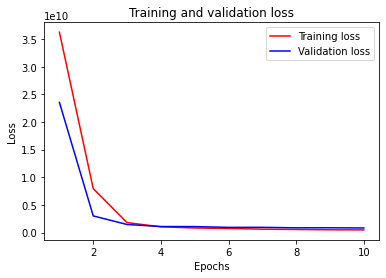

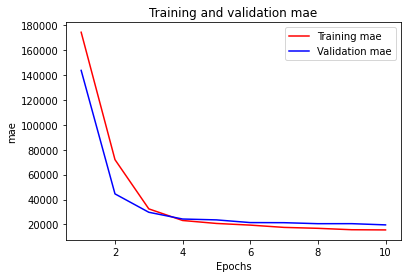

In [16]:
history = history.history
def graphs(history):
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(1, len(history['loss']) + 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
 
    plt.clf()
 
    mae = history['mae']
    val_mae = history['val_mae']
    plt.plot(epochs, mae, 'r', label='Training mae')
    plt.plot(epochs, val_mae, 'b', label='Validation mae')
    plt.title('Training and validation mae')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()
 

graphs(history)

In [17]:
#считаем корреляцию
y_pred = My_Model.predict(x_test)
y_test = np.reshape(y_test, (y_test.shape[0]))
y_pred= np.reshape(y_pred, (y_pred.shape[0]))
СС = np.corrcoef(y_pred, y_test)
СС = СС[0][1]
print(f'Коэффициент корреляции: {СС}')

Коэффициент корреляции: 0.8739793476662061


In [18]:
#Подбираем наилучшую модель с помощью Keras Tuner

def create_model(hp):
  model = Sequential()
  activation_choice = hp.Choice("activation", 
                                values=['relu', 'selu', 'elu'])
  model.add(Dense(units=hp.Int("units_input", min_value=32,
                               max_value=1024,
                               step=32),
                  activation=activation_choice, 
                  input_shape=(x_train.shape[1], )))
  model.add(Dropout(0.3))
  for i in range(hp.Choice('hidden_layers', values=[1,2,3])):
    model.add(Dense(units=hp.Int(f'layer_{i}_units_',
                                 min_value=32//(i+1),
                                 max_value=512//(i+1), 
                                 step=64//(i+1)),
                     activation=activation_choice))
  model.add(Dense(1))
  model.compile(optimizer='rmsprop', 
                loss="mse",
                metrics=["mae"])
  model.summary()
  return model


def search_best_model(x_train_norm, y_train):
  #поиск модели с помощью hyperband
  tuner = Hyperband(create_model, objective="loss", max_epochs=10, hyperband_iterations=3)
  tuner.search(x_train, y_train, batch_size=300, epochs=1, validation_split=0.2)
  tuner.results_summary()
  print("\n\n\nfound best model:\n\n\n")
  best_params = tuner.get_best_hyperparameters()[0]
  best_model = tuner.hypermodel.build(best_params)
  best_model.summary()
  return best_model
  

best_model = search_best_model(x_train, y_train)

Trial 90 Complete [00h 00m 02s]
loss: 30133450752.0

Best loss So Far: 24511322112.0
Total elapsed time: 00h 02m 38s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
activation: relu
units_input: 800
hidden_layers: 3
layer_0_units_: 288
layer_1_units_: 208
layer_2_units_: 136
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 24511322112.0
Trial summary
Hyperparameters:
activation: selu
units_input: 800
hidden_layers: 3
layer_0_units_: 352
layer_1_units_: 240
layer_2_units_: 136
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 30133450752.0
Trial summary
Hyperparameters:
activation: relu
units_input: 704
hidden_layers: 2
layer_0_units_: 416
layer_1_units_: 176
layer_2_units_: 73
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 36013158400.0
Trial summary
Hyperparameters:
a

In [19]:
#Обучение найденной модели
history = best_model.fit(x_train, y_train, epochs=10, batch_size=20, validation_split=0.2)
best_history = history.history

Epoch 1/10
41/41 [==============================] - 1s 14ms/step - loss: 34172346221.7143 - mae: 168272.1920 - val_loss: 15079107584.0000 - val_mae: 114077.1797
Epoch 2/10
41/41 [==============================] - 0s 8ms/step - loss: 8543433910.8571 - mae: 78354.7248 - val_loss: 2292290816.0000 - val_mae: 37897.5586
Epoch 3/10
41/41 [==============================] - 0s 8ms/step - loss: 1903630311.6190 - mae: 33506.8780 - val_loss: 1454502912.0000 - val_mae: 29176.2422
Epoch 4/10
41/41 [==============================] - 0s 7ms/step - loss: 1477734389.3333 - mae: 25863.1583 - val_loss: 1450466688.0000 - val_mae: 28345.9688
Epoch 5/10
41/41 [==============================] - 0s 7ms/step - loss: 1074255766.8571 - mae: 22883.1686 - val_loss: 1145290624.0000 - val_mae: 25114.7852
Epoch 6/10
41/41 [==============================] - 0s 8ms/step - loss: 920073603.0476 - mae: 21873.2174 - val_loss: 1011733248.0000 - val_mae: 22554.4883
Epoch 7/10
41/41 [==============================] - 0s 7ms/s

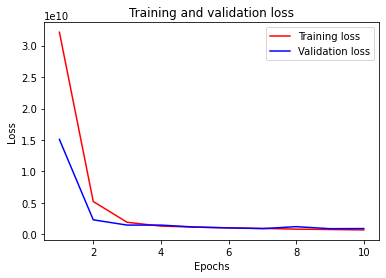

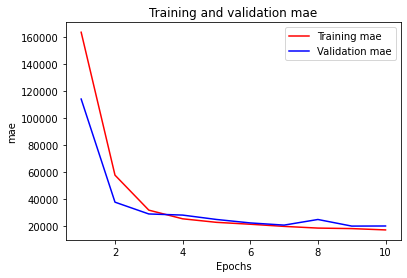

In [21]:
#Графики новой модели
graphs(best_history)

In [22]:
#Корреляция новой модели 
predicted_y_tuner = best_model.predict(x_test)
predicted_y_tuner = np.round(predicted_y_tuner, 0)

predicted_y_tuner = np.reshape(predicted_y_tuner, (predicted_y_tuner.shape[0]))

СС_tuner = np.corrcoef(predicted_y_tuner, y_test)
СС_tuner = СС_tuner[0][1]
print(f'Коэффициаент корреляция с тюнером: {СС_tuner}')

Коэффициаент корреляция с тюнером: 0.8812196624042009
